# Brain Tumor Segmentation  Unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
f="/content/drive/MyDrive/archive.zip"
with ZipFile(f,'r') as z:
  z.extractall()
  print('done')

done


**The process of segmenting tumor from MRI image of a brain is one of the highly focused areas in the community of medical science as MRI is noninvasive imaging. Therefore, I decided to create Brain Tumor Segmentation Notebook  that you can easily use the capabilities of this powerful tool. I am currently in the early stages of designing this Notebook and will be constantly updating these codes to get to a usable version.**

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from tensorflow.keras.layers import Concatenate, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.model_selection import train_test_split
import os
import nibabel as nib
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
import glob
import skimage.io as io
import skimage.color as color
import random as r
import math
! pip install nilearn
from nilearn import plotting
#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'):

    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_327/BraTS20_Training_327_flair.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_327/BraTS20_Training_327_seg.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_327/BraTS20_Training_327_t2.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_327/BraTS20_Training_327_t1ce.nii
/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Train

# **BraTs2020 Data Visualization**
**In this section, I select a sample data from Brats2020  and visualize it to see the input data**

In [ ]:
#Flair= nib.load('../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Flair= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_flair.nii')
Seg= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii')
T1= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii')
T1ce= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1ce.nii')
T2= nib.load('/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii')

**Fluid-attenuated inversion recovery (FLAIR) :**

**FLAIR is an MRI sequence with an inversion recovery set to null fluids. For example, it can be used in brain imaging to suppress cerebrospinal fluid (CSF) effects on the image, so as to bring out the periventricular hyperintense lesions, such as multiple sclerosis (MS) plaques**

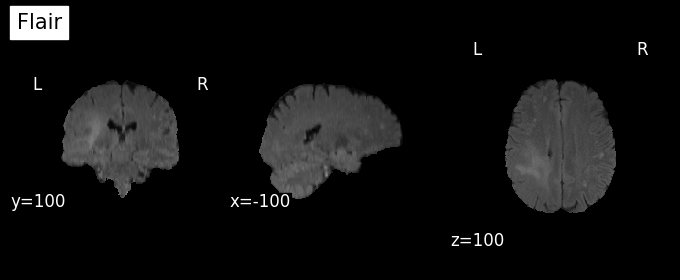

In [ ]:
plotting.plot_anat(Flair,cut_coords=[-100, 100, 100],title="Flair",draw_cross =False)

**Manual segmentation that annotated by an expert**

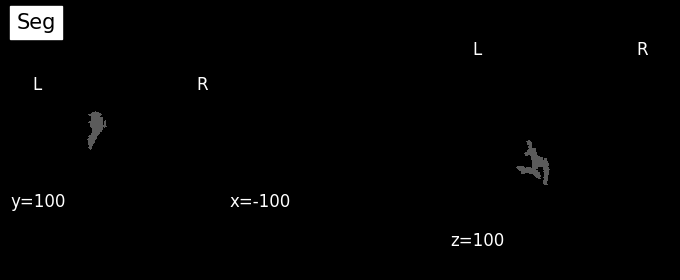

In [ ]:
plotting.plot_anat(Seg,cut_coords=[-100, 100, 100],title="Seg",draw_cross =False)

**T1 weighted images :**

**Magnetic resonance imaging uses the resonance of the protons to generate images. Protons are excited by a radio frequency pulse at an appropriate frequency (Larmor frequency) and then the excess energy is released in the form of a minuscule amount of heat to the surroundings as the spins return to their thermal equilibrium. The magnetization of the proton ensemble goes back to its equilibrium value with an exponential curve characterized by a time constant T1.**

**T1 weighted images can be obtained by setting short repetition time (TR) such as < 750 ms and echo time (TE) such as < 40 ms in conventional spin echo sequences, while in Gradient Echo Sequences they can be obtained by using flip angles of larger than 50o while setting TE values to less than 15 ms.**

**T1 is significantly different between grey matter and white matter and is used when undertaking brain scans. A strong T1 contrast is present between fluid and more solid anatomical structures, making T1 contrast suitable for morphological assessment of the normal or pathological anatomy, e.g., for musculoskeletal applications.**

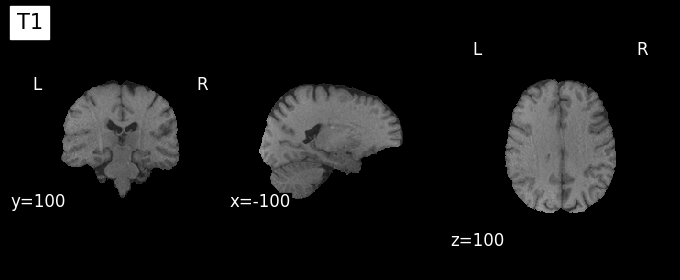

In [ ]:
plotting.plot_anat(T1,cut_coords=[-100, 100, 100],title="T1",draw_cross =False)

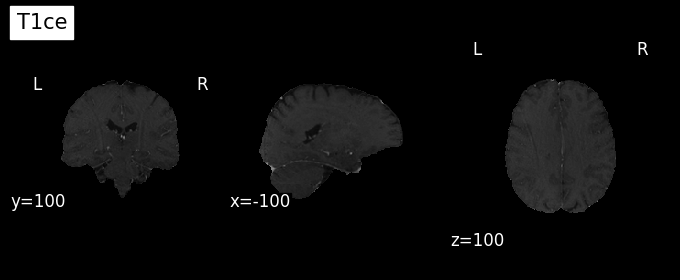

In [ ]:
plotting.plot_anat(T1ce,cut_coords=[-100, 100, 100],title="T1ce",draw_cross =False)

**T2 weighted image :**


**T2 weighted image (T2WI) is one of the basic pulse sequences in MRI. The sequence weighting highlights differences in the T2 relaxation time of tissues.**

**The amount of T2 decay a tissue experiences depends on multiple factors. Each tissue has an inherent T2 value, but external factors (such as magnetic field inhomogeneity) can decrease the T2 relaxation time. This additional effect is captured in T2*. The refocusing pulse in spin-echo sequences helps to mitigate these extraneous influences on the T2 relaxation time, trying to keep the image T2 weighted rather than T2* weighted.**

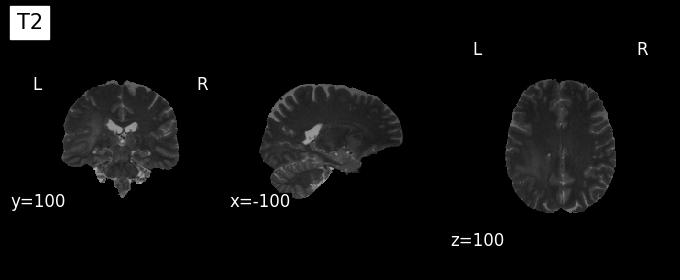

In [ ]:
plotting.plot_anat(T2,cut_coords=[-100, 100, 100],title="T2",draw_cross =False)

# Data Preprocessing

In [ ]:
Path= '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
#Path='D:/BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
p=os.listdir(Path)
Input_Data= []
def Data_Preprocessing(modalities_dir):
    all_modalities = []
    for modality in modalities_dir:
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities
for i in p[:20]:
    brain_dir = os.path.normpath(Path+'/'+i)
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)


**Check the output**

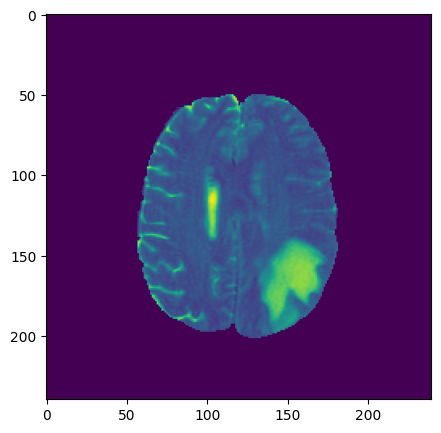

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[1][100,:,:,3]
imgplot = plt.imshow(immmg)
plt.show()

**concatenate images**

In [ ]:
def Data_Concatenate(Input_Data):
    counter=0
    Output= []
    for i in range(5):
        print('$')
        c=0
        counter=0
        for ii in range(len(Input_Data)):
            if (counter != len(Input_Data)):
                a= Input_Data[counter][:,:,:,i]
                print('a={}'.format(a.shape))
                b= Input_Data[counter+1][:,:,:,i]
                print('b={}'.format(b.shape))
                if(counter==0):
                    c= np.concatenate((a, b), axis=0)
                    print('c1={}'.format(c.shape))
                    counter= counter+2
                else:
                    c1= np.concatenate((a, b), axis=0)
                    c= np.concatenate((c, c1), axis=0)
                    print('c2={}'.format(c.shape))
                    counter= counter+2
        c= c[:,:,:,np.newaxis]
        Output.append(c)
    return Output

In [ ]:
InData= Data_Concatenate(Input_Data)

$
a=(155, 240, 240)
b=(155, 240, 240)
c1=(310, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(620, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(930, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1240, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1550, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1860, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2170, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2480, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2790, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(3100, 240, 240)
$
a=(155, 240, 240)
b=(155, 240, 240)
c1=(310, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(620, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(930, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1240, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1550, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(1860, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2170, 240, 240)
a=(155, 240, 240)
b=(155, 240, 240)
c2=(2480, 240,

In [ ]:
AIO= concatenate(InData, axis=3)
#AIO=tf.keras.layers.concatenate(InData, axis=3)
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32')
TRL=np.array(AIO[:,:,:,4],dtype='float32')

In [ ]:
X_train , X_test, Y_train, Y_test = train_test_split(TR, TRL, test_size=0.15, random_state=32)
AIO=TRL=0

**Implement Unet (Attention UNet)**

In [ ]:
'''

############ Attention U-Net #######################

'''

def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def conv_block(x, filter_size, size):

    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)

    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)

    return conv


def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet,

    '''
    # network structure
    FILTER_NUM = 32
    FILTER_SIZE = 3
    UP_SAMP_SIZE = 2

    inputs = layers.Input(input_shape, dtype=tf.float32)

############# ENCODER
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM)

##########DECODER
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM)

    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM)

    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM)

    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM)


    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel


    model = Model(inputs, conv_final, name="Attention_UNet")
    return model

In [ ]:
'''

##############    UNet    #################


def Convolution(input_tensor,filters):

    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def model(input_shape):

    inputs = Input((input_shape))

    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)

    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)

    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)

    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)

    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)

    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)

    upsample_7 = concatenate([upsample_7, conv_3])

    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)

    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)

    upsample_9 = concatenate([upsample_9, conv_1])

    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

  '''

In [ ]:
# Loding the Light weighted CNN
# model = model(input_shape = (240,240,1))
model=Attention_UNet(input_shape = (240,240,1))
model.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [ ]:
# Computing Dice_Coefficient
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Computing mIoU
def IoU()

In [ ]:
# Compiling the model
Adam=optimizers.Adam(lr=0.001)
model.compile(optimizer=Adam, loss='binary_crossentropy', metrics=['accuracy',dice_coef,precision,sensitivity,specificity])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Fitting the model over the data
history = model.fit(X_train,Y_train,batch_size=32,epochs=40,validation_split=0.20,verbose=1,initial_epoch=0)

Epoch 1/40
66/66 [==============================] - 119s 1s/step - loss: 0.6654 - accuracy: 0.8402 - dice_coef: 0.0582 - precision: 0.0688 - sensitivity: 0.9748 - specificity: 0.8466 - val_loss: 0.6588 - val_accuracy: 0.3692 - val_dice_coef: 0.0151 - val_precision: 0.0044 - val_sensitivity: 0.2842 - val_specificity: 0.3710
Epoch 2/40
66/66 [==============================] - 66s 996ms/step - loss: 0.6117 - accuracy: 0.8925 - dice_coef: 0.0634 - precision: 0.1079 - sensitivity: 0.9526 - specificity: 0.8997 - val_loss: 0.6886 - val_accuracy: 0.2365 - val_dice_coef: 0.0400 - val_precision: 0.0119 - val_sensitivity: 0.9227 - val_specificity: 0.2358
Epoch 3/40
66/66 [==============================] - 66s 1s/step - loss: 0.5764 - accuracy: 0.9207 - dice_coef: 0.0653 - precision: 0.1467 - sensitivity: 0.9263 - specificity: 0.9286 - val_loss: 0.6068 - val_accuracy: 0.9894 - val_dice_coef: 0.0345 - val_precision: 835.3914 - val_sensitivity: 0.7070 - val_specificity: 0.9992
Epoch 4/40
66/66 [====

In [ ]:
# Evaluating the model on the training and testing data
model.evaluate(x=X_train, y=Y_train, batch_size=32 , verbose=1, sample_weight=None, steps=None)
model.evaluate(x=X_test, y=Y_test, batch_size=32, verbose=1, sample_weight=None, steps=None)

15/15 [==============================] - 9s 605ms/step - loss: -0.0192 - accuracy: 0.9897 - dice_coef: 0.2973 - precision: 0.8112 - sensitivity: 0.9182 - specificity: 0.9974


[-0.019205840304493904,
 0.9896922707557678,
 0.2973337769508362,
 0.8111709952354431,
 0.918224036693573,
 0.9974190592765808]

In [ ]:
# Accuracy vs Epoch
def Accuracy_Graph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

# Dice Similarity Coefficient vs Epoch
def Dice_coefficient_Graph(history):

    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    #plt.title('Dice_Coefficient')
    plt.ylabel('Dice_Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()
# Loss vs Epoch
def Loss_Graph(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)
    plt.show()

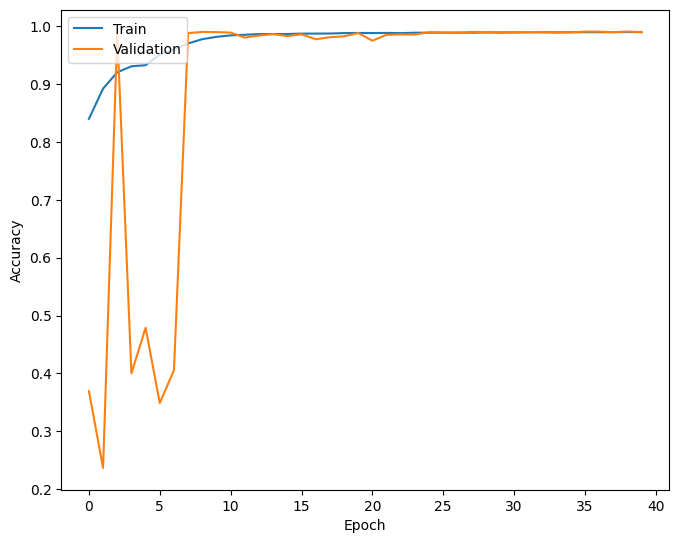

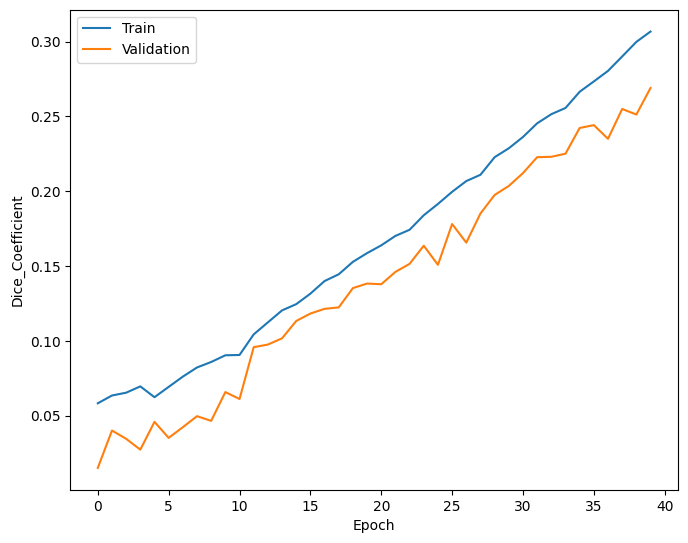

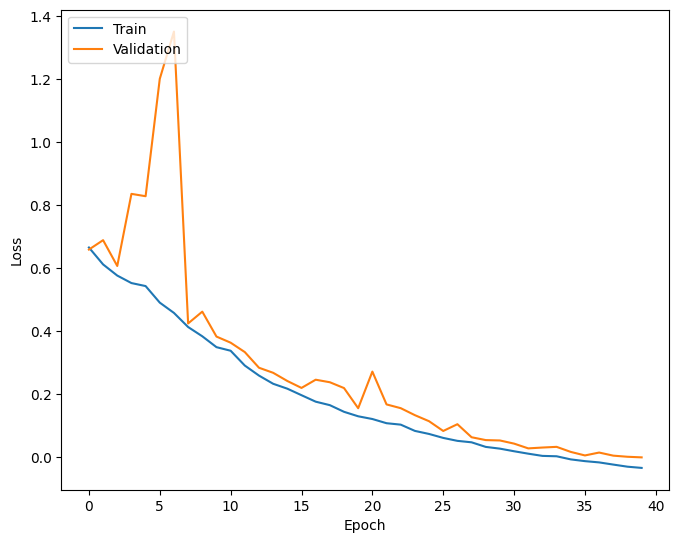

In [ ]:
# Plotting the Graphs of Accuracy, Dice_coefficient, Loss at each epoch on Training and Testing data
Accuracy_Graph(history)
Dice_coefficient_Graph(history)
Loss_Graph(history)

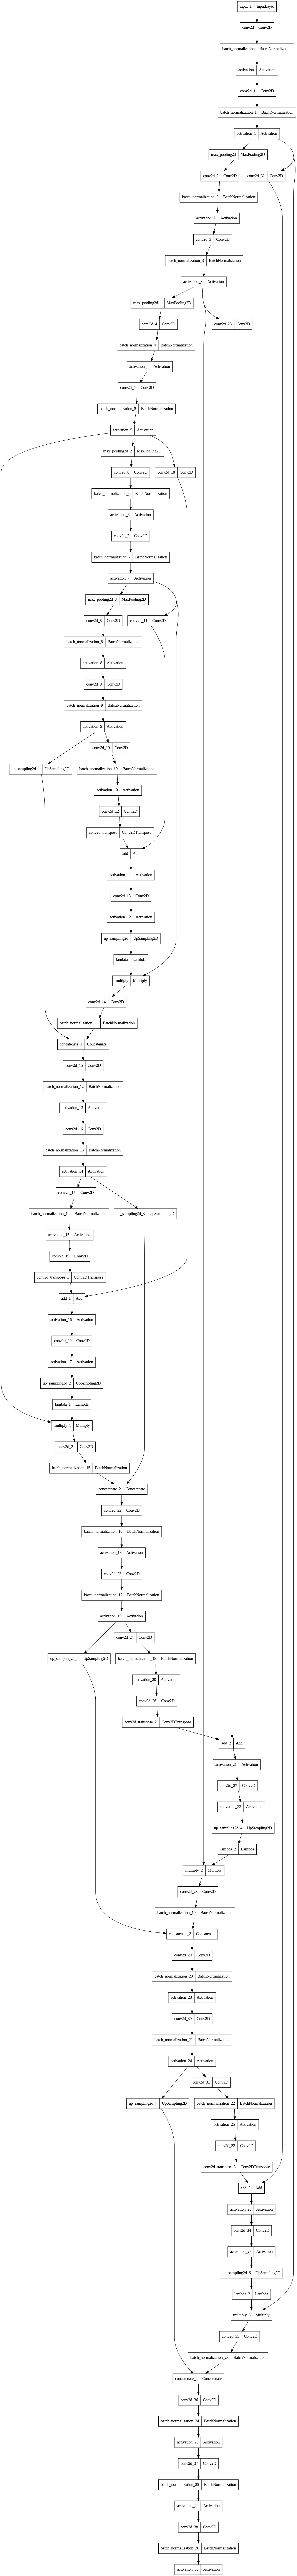

In [ ]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

In [ ]:
model.save('./BraTs2020.h5')

In [ ]:
model.load_weights('./BraTs2020.h5')

In [ ]:
X_train=X_test=Y_train=Y_test=0

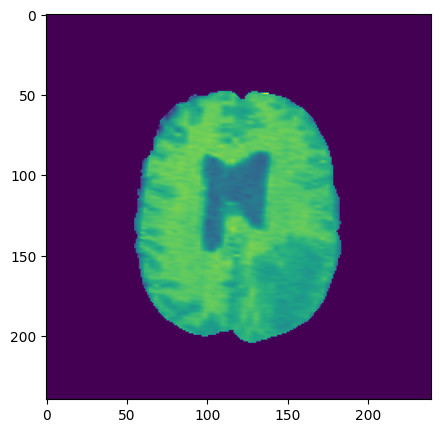

In [ ]:
fig = plt.figure(figsize=(5,5))
immmg = TR[250,:,:]
imgplot = plt.imshow(immmg)
plt.show()

In [ ]:
pref_Tumor = model.predict(TR)

97/97 [==============================] - 23s 228ms/step


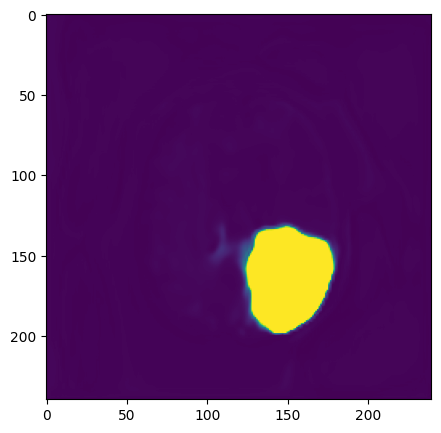

In [ ]:
##### predicted mass
fig = plt.figure(figsize=(5,5))
immmg = pref_Tumor[250,:,:,0]
imgplot = plt.imshow(immmg)
plt.show()

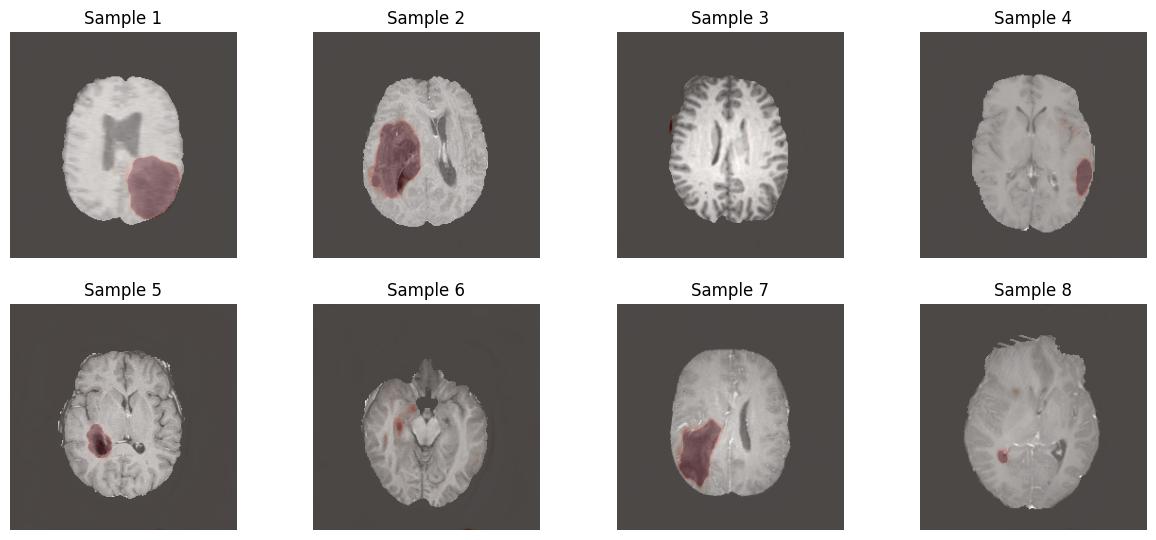

In [ ]:
plt.figure(figsize=(15,10))


plt.subplot(341)
plt.title('Sample 1')
plt.axis('off')
plt.imshow(np.squeeze(TR[250,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[250,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(342)
plt.title('Sample 2')
plt.axis('off')
plt.imshow(np.squeeze(TR[550,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[550,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(343)
plt.title('Sample 3')
plt.axis('off')
plt.imshow(np.squeeze(TR[400,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[400,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(344)
plt.title('Sample 4')
plt.axis('off')
plt.imshow(np.squeeze(TR[690,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[690,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(345)
plt.title('Sample 5')
plt.axis('off')
plt.imshow(np.squeeze(TR[850,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[850,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(346)
plt.title('Sample 6')
plt.axis('off')
plt.imshow(np.squeeze(TR[1450,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1450,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(347)
plt.title('Sample 7')
plt.axis('off')
plt.imshow(np.squeeze(TR[1800,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[1800,:,:]),alpha=0.3,cmap='Reds')

plt.subplot(348)
plt.title('Sample 8')
plt.axis('off')
plt.imshow(np.squeeze(TR[60,:,:]),cmap='gray')
plt.imshow(np.squeeze(pref_Tumor[60,:,:]),alpha=0.3,cmap='Reds')